In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scienceplots
plt.style.use(['science','ieee'])

In [106]:
# now lets try our Q with all variable
# Define the Lorentzian function
def lorentzian(x, x0, a, gamma):
  return (a/np.pi) * (gamma/2 / ((x - x0)**2 + (gamma/2)**2))

def E(t, tau, omega):
    return np.exp(-2*np.log(2)*t**2/tau**2) * np.exp(-1j*omega*t)

def dadq(om, OmR, T2, chi3, N, m):
    # molecular polarizability tensor
    eps_0 = 8.85e-12
    return np.sqrt(3*chi3*eps_0*m*(OmR**2-om**2-2j*om/T2)/N)

def dsdt(omS, OmR, m , dadq_val):
    # scattering cross section
    h_bar = 6.63e-34/2/np.pi
    c = 3e8
    return (omS/c)**4*h_bar*dadq_val**2/2/m/OmR

def Q_om(dadq_val,E10,E20,OmR, om,T2):
    eps_0 = 8.85e-12
    return eps_0*dadq_val*E10*np.conjugate(E20)/(OmR**2-om**2-2j*om/T2)

def chi3_om(dadq_val,OmR, om,T2, N, m):
    eps_0 = 8.85e-12
    return N*dadq_val**2/(m*eps_0*(OmR**2-om**2-2j*om/T2))

def xi_CARS(chi3_val,L,xi1,xi2,xi3,delk,n1,n2,n3,nas,w0,tau,lambda_as):
    c = 3e8
    eps_0 = 8.85e-12
    return 48*np.log(2)*np.abs(chi3_val)**2*L**2*xi1*xi2*xi3*np.sinc(delk*L/2)/(np.sqrt(3)*np.pi*c**2*eps_0**2*n1*n2*n3*nas*w0**4*tau**2*lambda_as**2)

def draw_line_width(ax, y, x, level=0.5, method = 'descrete', ann_txt = r"$\Delta\nu$="):
    line_width, left_pt, right_pt = 0, 0, 0
    #First do descrete method to get intitial parameters
    half_max = np.min(y) + level * (np.max(y)-np.min(y))
    indices = np.where(y >= half_max)[0]
    if len(indices) < 2:
        return None  # Not enough points above half max
    left_idx,right_idx = indices[0], indices[-1]
    line_width,left_pt, right_pt = x[right_idx] - x[left_idx],x[left_idx], x[right_idx]
    if method == 'lorentzian':
        # Fit the Lorentzian function to the noisy data
        popt, _ = curve_fit(lorentzian, x, y/np.max(y), p0=[0, 1, line_width]) # Initial guesses: [x0, a, gamma]
        fitted_x0, fitted_a, fitted_gamma = popt
        line_width,left_pt, right_pt = fitted_gamma, -fitted_gamma/2, fitted_gamma/2
    x_min,x_max = ax.get_xlim()
    arrow_len = (x_max-x_min)*0.1
    ax.annotate("", xy=(left_pt, half_max), xytext=(left_pt-arrow_len, half_max), arrowprops=dict(arrowstyle="->"))
    ax.annotate("", xy=(right_pt, half_max), xytext=(right_pt+arrow_len, half_max), arrowprops=dict(arrowstyle="->"))
    ax.text(right_pt+arrow_len, half_max, ann_txt+f"{line_width:.2f} THz")
    return ax

def kappa_Q(dadq_val,m,OmR):
    return dadq_val/4/m/OmR

def g_t(t, tau):
    return np.exp(-2*np.log(2)*t**2/tau**2)

def Q_ampl(t,tau,T2):
    #this is the inner integral of Phi(td)
    the = np.arange(-5*tau, 5*tau, 20e-15)
    return np.trapezoid(np.exp(-(t-the)/T2)*np.heaviside(t-the,1)*g_t(the,tau)**2,the)

def Q_t_feruz(tp,tau,T2, delOm):
    #this is the inner integral of Phi(td)
    the = np.arange(-5*tau, 5*tau, 20e-15)
    return np.abs(np.trapezoid(np.exp(-tp/T2+the/T2)*np.exp((-the)*1j*delOm)*np.heaviside(tp-the,1)*g_t(the,tau)**2,the))**2

def S_furuz(td_arr, tau, T2, A, floor, delOm):
    tp_arr = np.arange(np.min(td_arr)+5*tau, np.max(td_arr)-5*tau, 20e-15)
    Q = [Q_t_feruz(tp, tau, T2, delOm) for tp in tp_arr]
    S = np.zeros(len(td_arr))
    for i, td in enumerate(td_arr):
        I3 = np.sqrt(4*np.log(2)/tau**2/np.pi)*g_t(tp_arr-td, tau)**2
        S[i] = A*np.trapezoid(I3*Q,tp_arr)+floor
    return S

def Q_t(t, tau, kappa_Q_val, T2, A1, A2):
    return A1*A2*kappa_Q_val*Q_ampl(t,tau,T2)

def enr_2_E_field(xi, w0, tau):
    c = 3e8
    eps_0 = 8.85e-12
    return np.sqrt(8*xi*np.sqrt(np.log(2)/np.pi)/c/eps_0/np.pi/w0**2/tau)

def psi_t(t,tau,T2,tp_arr):
    #tp_arr = np.arange(-5*tau,5*tau,20e-15)
    #(2*np.log(2)/np.pi/tau**2)**(1/4)*
    return np.trapezoid(g_t(tp_arr-t,tau)*np.exp(-tp_arr/T2)*np.abs(np.array([Q_ampl(tp,tau,T2) for tp in tp_arr]))**2,tp_arr)

def kappa_as(N,omas_v, dadq_val, nas):
    c = 3e8
    eps_0 = 8.85e-12
    return -N*omas_v*dadq_val/4/eps_0/c/nas

def xi_cars_psi(N, omas_v , dadq_val,L,xi1,xi2,xi3,n1,n2,n3,nas,w0,tau,m,OmR):
    eps_0 = 8.85e-12
    c = 3e8
    return 128*np.log(2)**(3/2)*nas*kappa_as(N,omas_v, dadq_val, nas)**2*kappa_Q(dadq_val,m,OmR)**2*xi1*xi2*xi3*L**2/(3*np.pi**(7/2)*n1*n2*n3*eps_0*c**2*w0**2*tau**2)

In [61]:
c = 3e8  # Speed of light in m/s
lambda_as, lambda_1, lambda_3 = 700e-9, 1000e-9, 800e-9  # Wavelength in meters
lambda_2 = 1/(1/lambda_1+1/lambda_3-1/lambda_as)
omega_1,omega_2,omega_3 = 2 * np.pi * c / lambda_1, 2 * np.pi * c / lambda_2, 2 * np.pi * c / lambda_3  # Angular frequency
omega_as = omega_3 + (omega_1-omega_2)
omega_s = omega_3 - (omega_1-omega_2)
#lambda_as = 700e-9#2 * np.pi * c / omega_as
lambda_s = 2 * np.pi * c / omega_s
xi1,xi2,xi3 = 1e-9, 1e-9, 1e-9  # Pulse energies
n1,n2,n3,nas = 2.5,2.5,2.5,2.5  # Refractive index
tau_p = 200e-15  # Pulse duration in seconds
L = 0.7e-6  # Interaction length in meters
w0 = (0.35e-6)/2  # Beam waist in meters
epsilon_0 = 8.85e-12  # Vacuum permittivity in F/m
chi3 = 1e-23  # Third-order susceptibility in m^2/V^2
tau = 200e-15 #pulse width
OmR = 50*2*np.pi*1e12#omega_1 - omega_2
N = 1e29
m = 1e-27
T2 = 500e-15
dadq_val = dadq(OmR, OmR, T2, chi3, N, m)
dsdt_val = dsdt(omega_s,OmR, m ,dadq_val)
A1,A2,A3 = 1e10,1e10,1e10#enr_2_E_field(xi1,w0,tau),enr_2_E_field(xi2,w0,tau),enr_2_E_field(xi3,w0,tau)
kappa_Q_val = kappa_Q(dadq_val, m, OmR)

In [ ]:
#section 1: spectral domain CARS
xi_as = 48*np.abs(chi3)**2*np.log(2)*xi1*xi2*xi3*L**2/(np.sqrt(3)*c**2*epsilon_0**2*np.pi*n1*n2*n3*nas*w0**4*tau**2*lambda_as**2)
xi_as/1e-15

np.float64(0.059190897721671194)

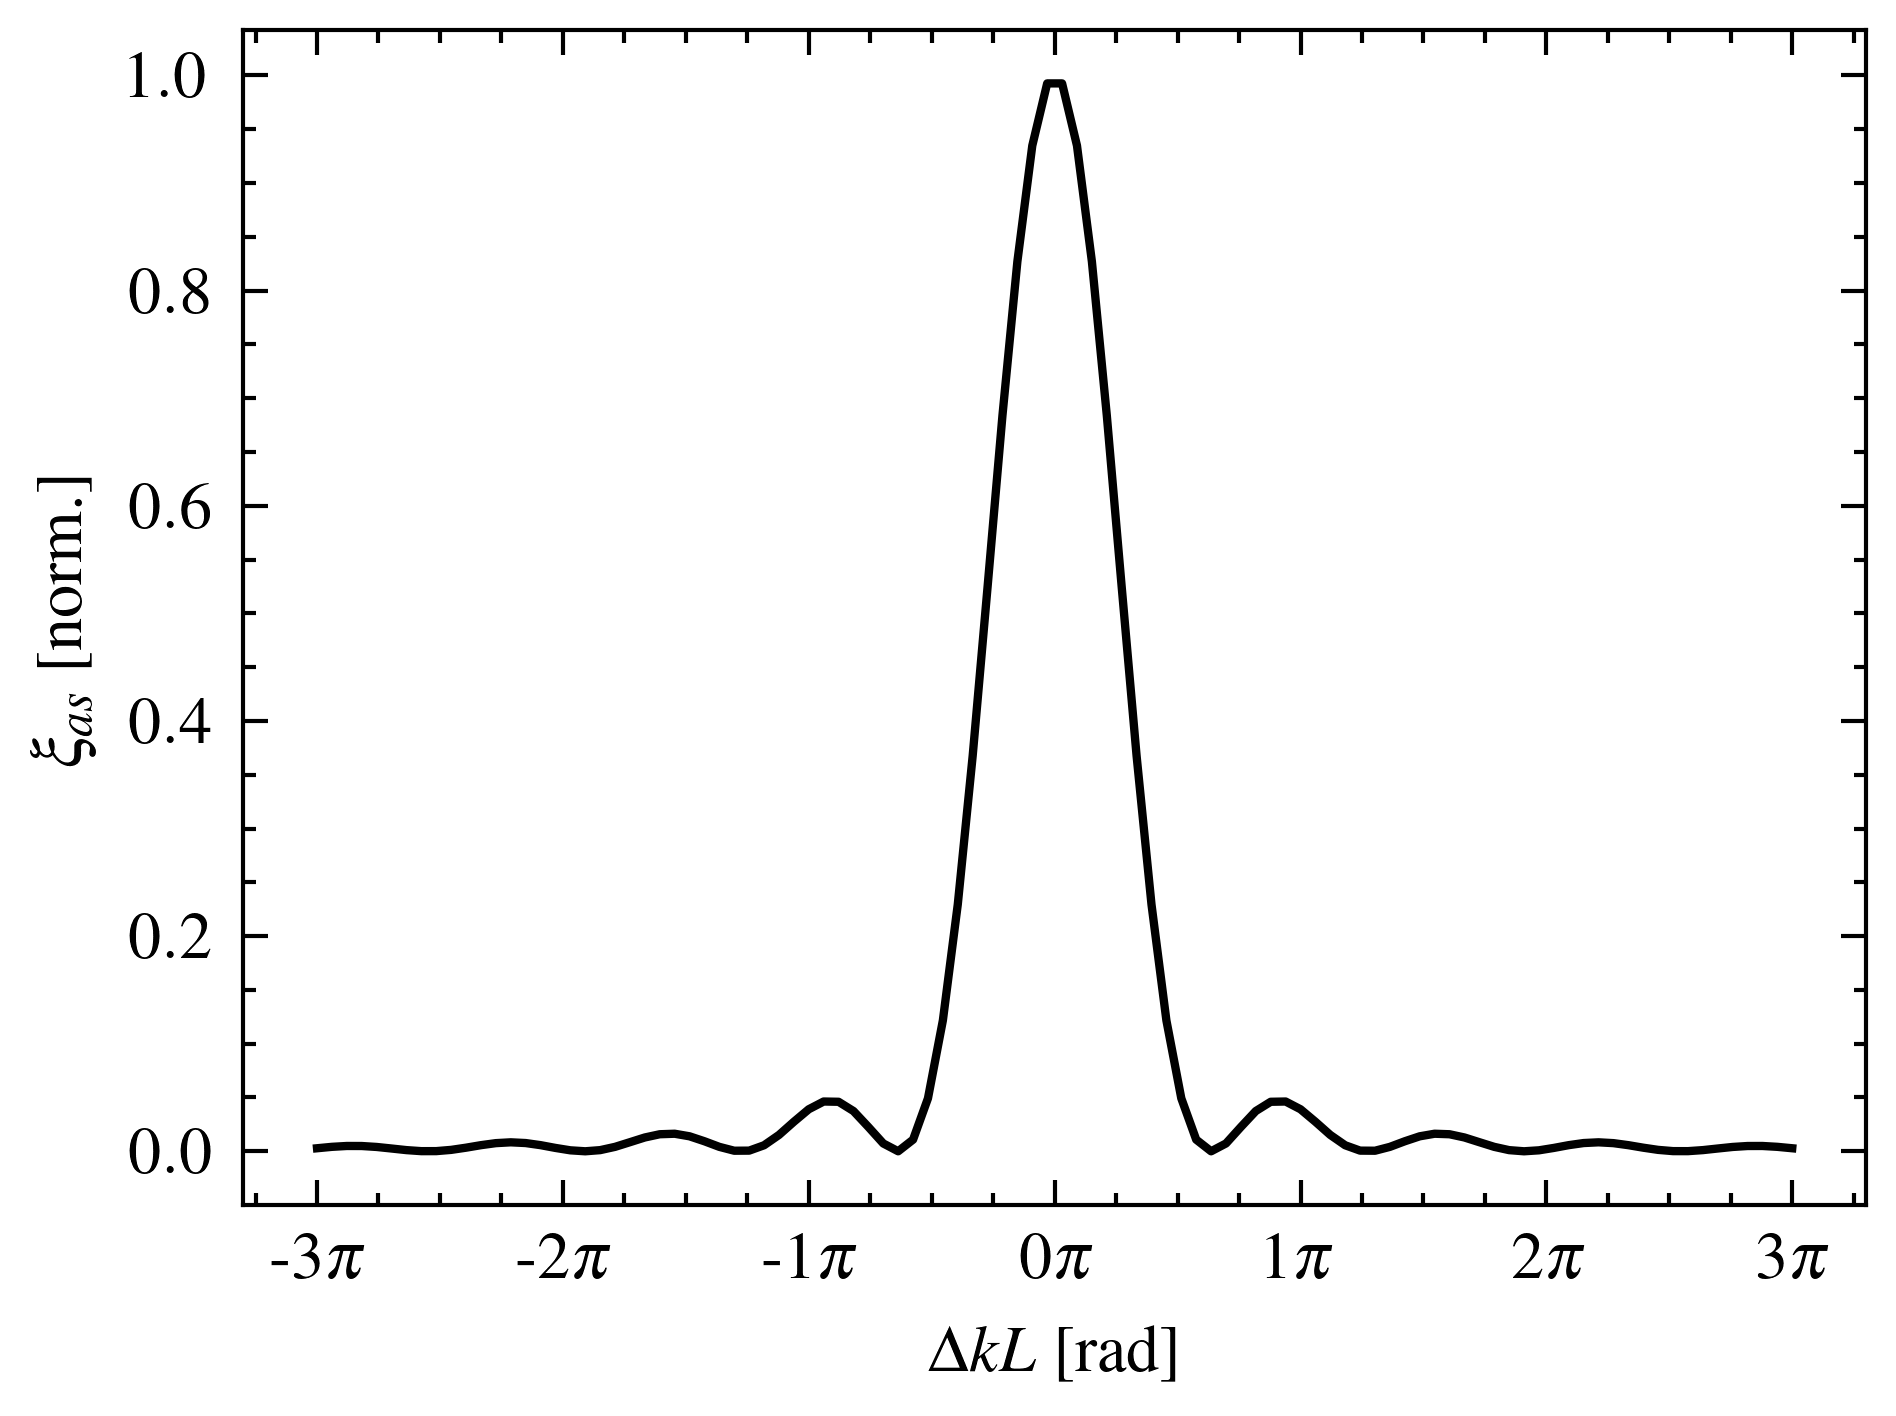

In [38]:
#section 1 del_kL vs xi_as plot
delkL = np.linspace(-3,3,100)*np.pi
xi_arr_kl = np.sinc(delkL/2)**2

plt.plot(delkL, xi_arr_kl)
plt.xlabel(r'$\Delta k L$ [rad]')
plt.ylabel(r'$\xi_{as}$ [norm.]')
plt.xticks(np.arange(-3,3+1,1)*np.pi, [f'{i}'+r'$\pi$' for i in np.arange(-3,3+1,1)])
plt.tight_layout()
plt.savefig(r'C:\Users\dinus\OneDrive\Desktop\Oral Comp Exam\Written comp exam\images\sec_1_fig_1.png', dpi=300, transparent=True)

In [39]:
OmR

314159265358979.3

In [40]:
np.abs(dadq(OmR, OmR, T2, chi3, N, m))

np.float64(5.776133133950741e-32)

In [41]:
#section 2: max Q
C_max = Q_ampl(0,200e-15, 500e-15)
print(C_max)
print(np.abs(A1*A2*kappa_Q_val*C_max)/1e-12)

1.0349387298464421e-13
0.4757096597361319


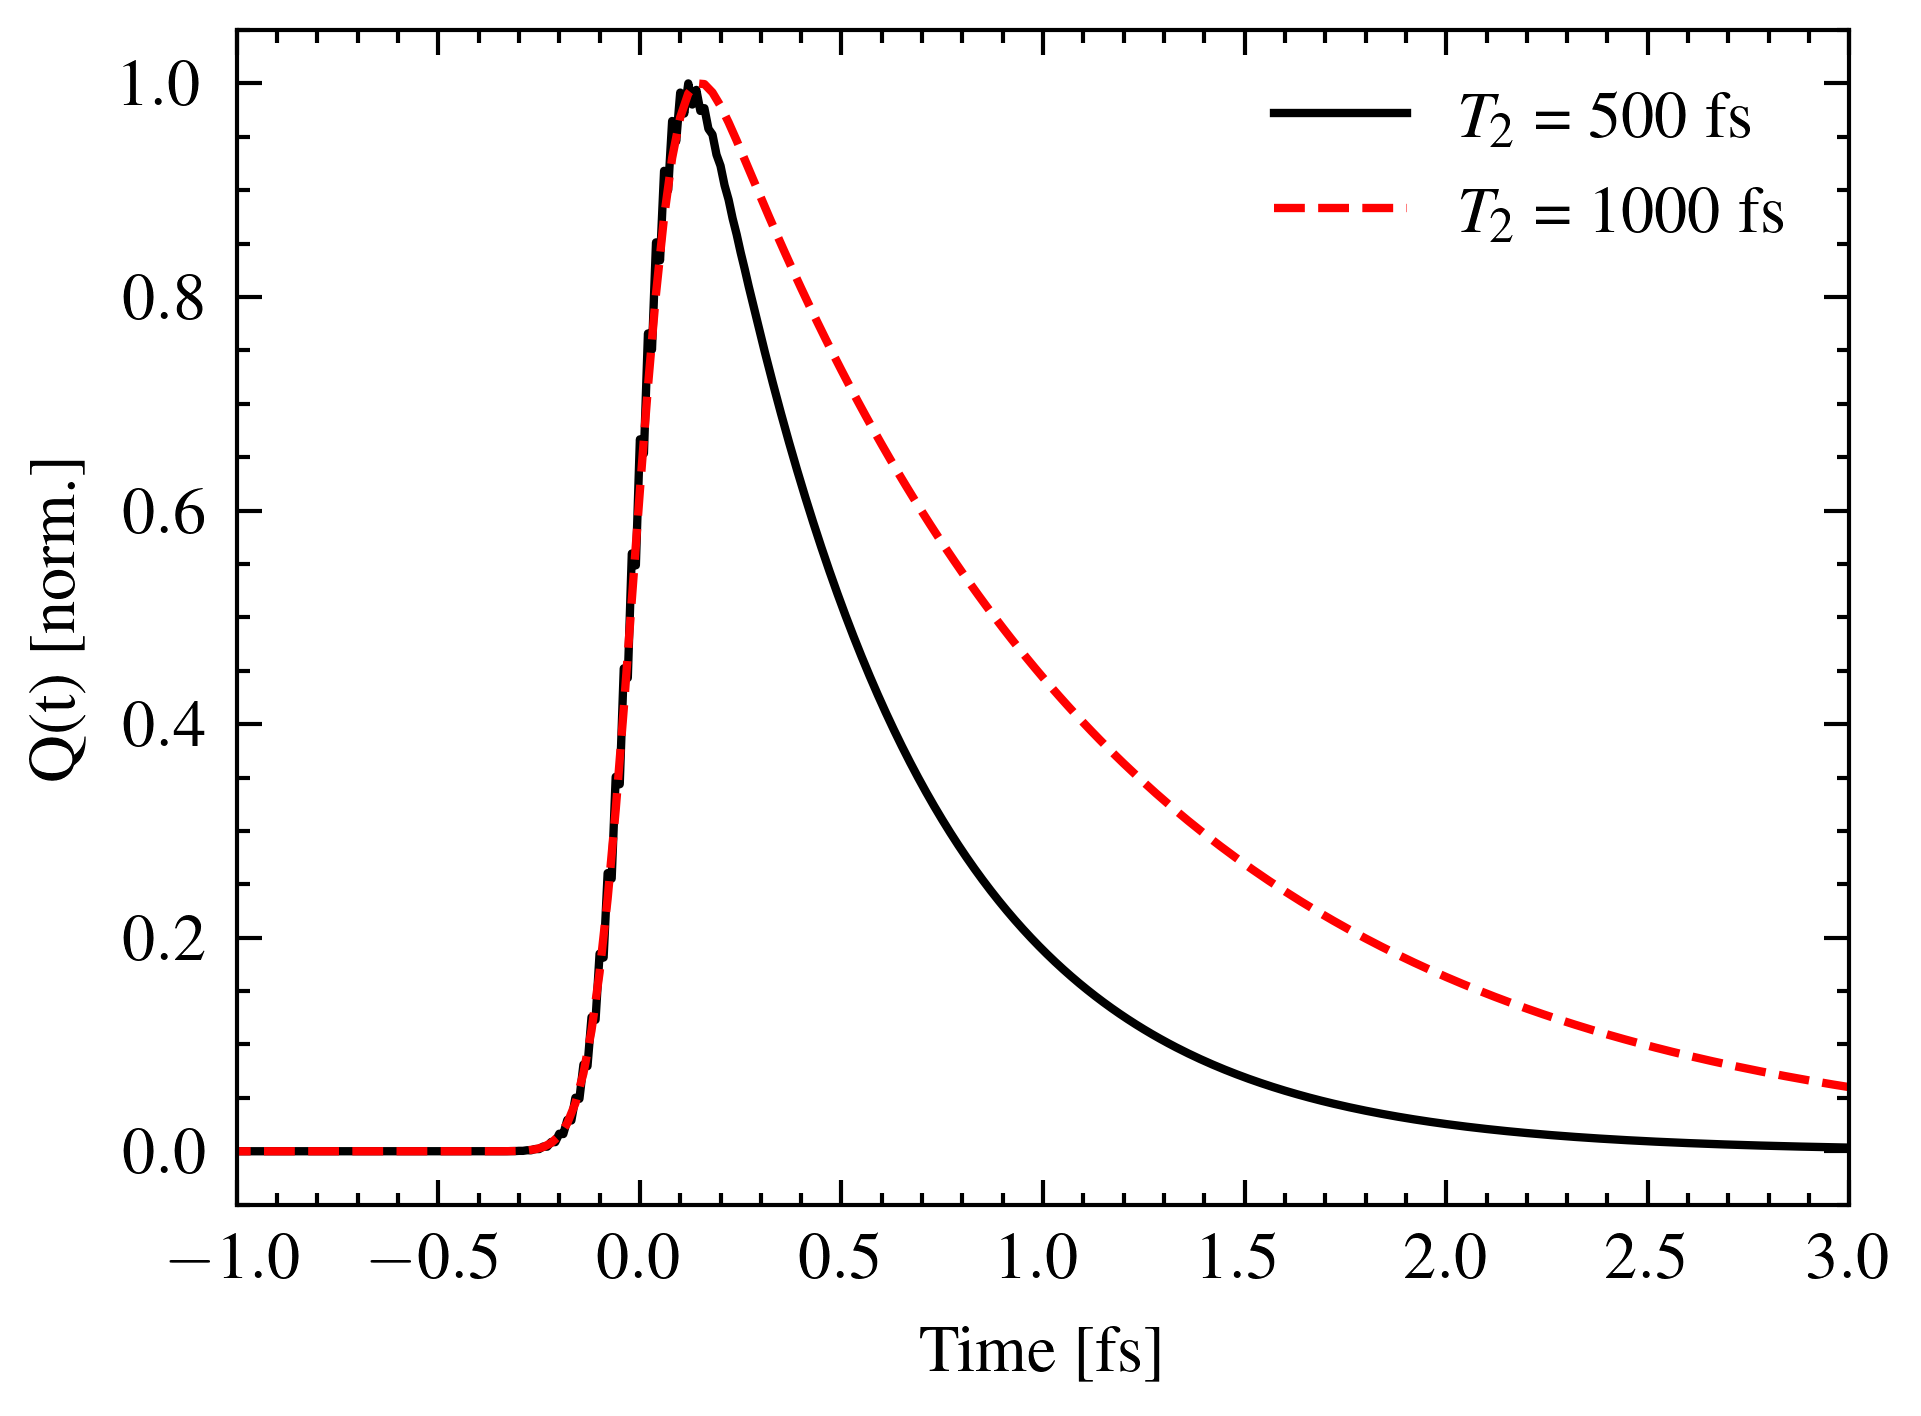

In [42]:
#section 1 del_kL vs xi_as plot
T2_arr = np.array([500,1000])*1e-15
dt_arr = T2_arr / 50  # small enough sampling
t_arr1 = np.arange(-5000e-15,10*T2_arr[0],dt_arr[0])
t_arr2 = np.arange(-5000e-15,10*T2_arr[1],dt_arr[1])
Q_t_arr1 = np.array([Q_ampl(t,tau, T2_arr[0]) for t in t_arr1])
Q_t_arr2 = np.array([Q_ampl(t,tau, T2_arr[1]) for t in t_arr2])

plt.plot(t_arr1*1e12, Q_t_arr1/np.max(Q_t_arr1), label = '$T_2$ = '+f'{(T2_arr[0]*1e15):.0f} fs')
plt.plot(t_arr2*1e12, Q_t_arr2/np.max(Q_t_arr2), label = '$T_2$ = '+f'{(T2_arr[1]*1e15):.0f} fs')
plt.xlabel(r'Time [fs]')
plt.ylabel(r'Q(t) [norm.]')
plt.legend()
plt.xlim(-1,3)
plt.tight_layout()
plt.savefig(r'C:\Users\dinus\OneDrive\Desktop\Oral Comp Exam\Written comp exam\images\sec_2_fig_1.png', dpi=300, transparent=True)

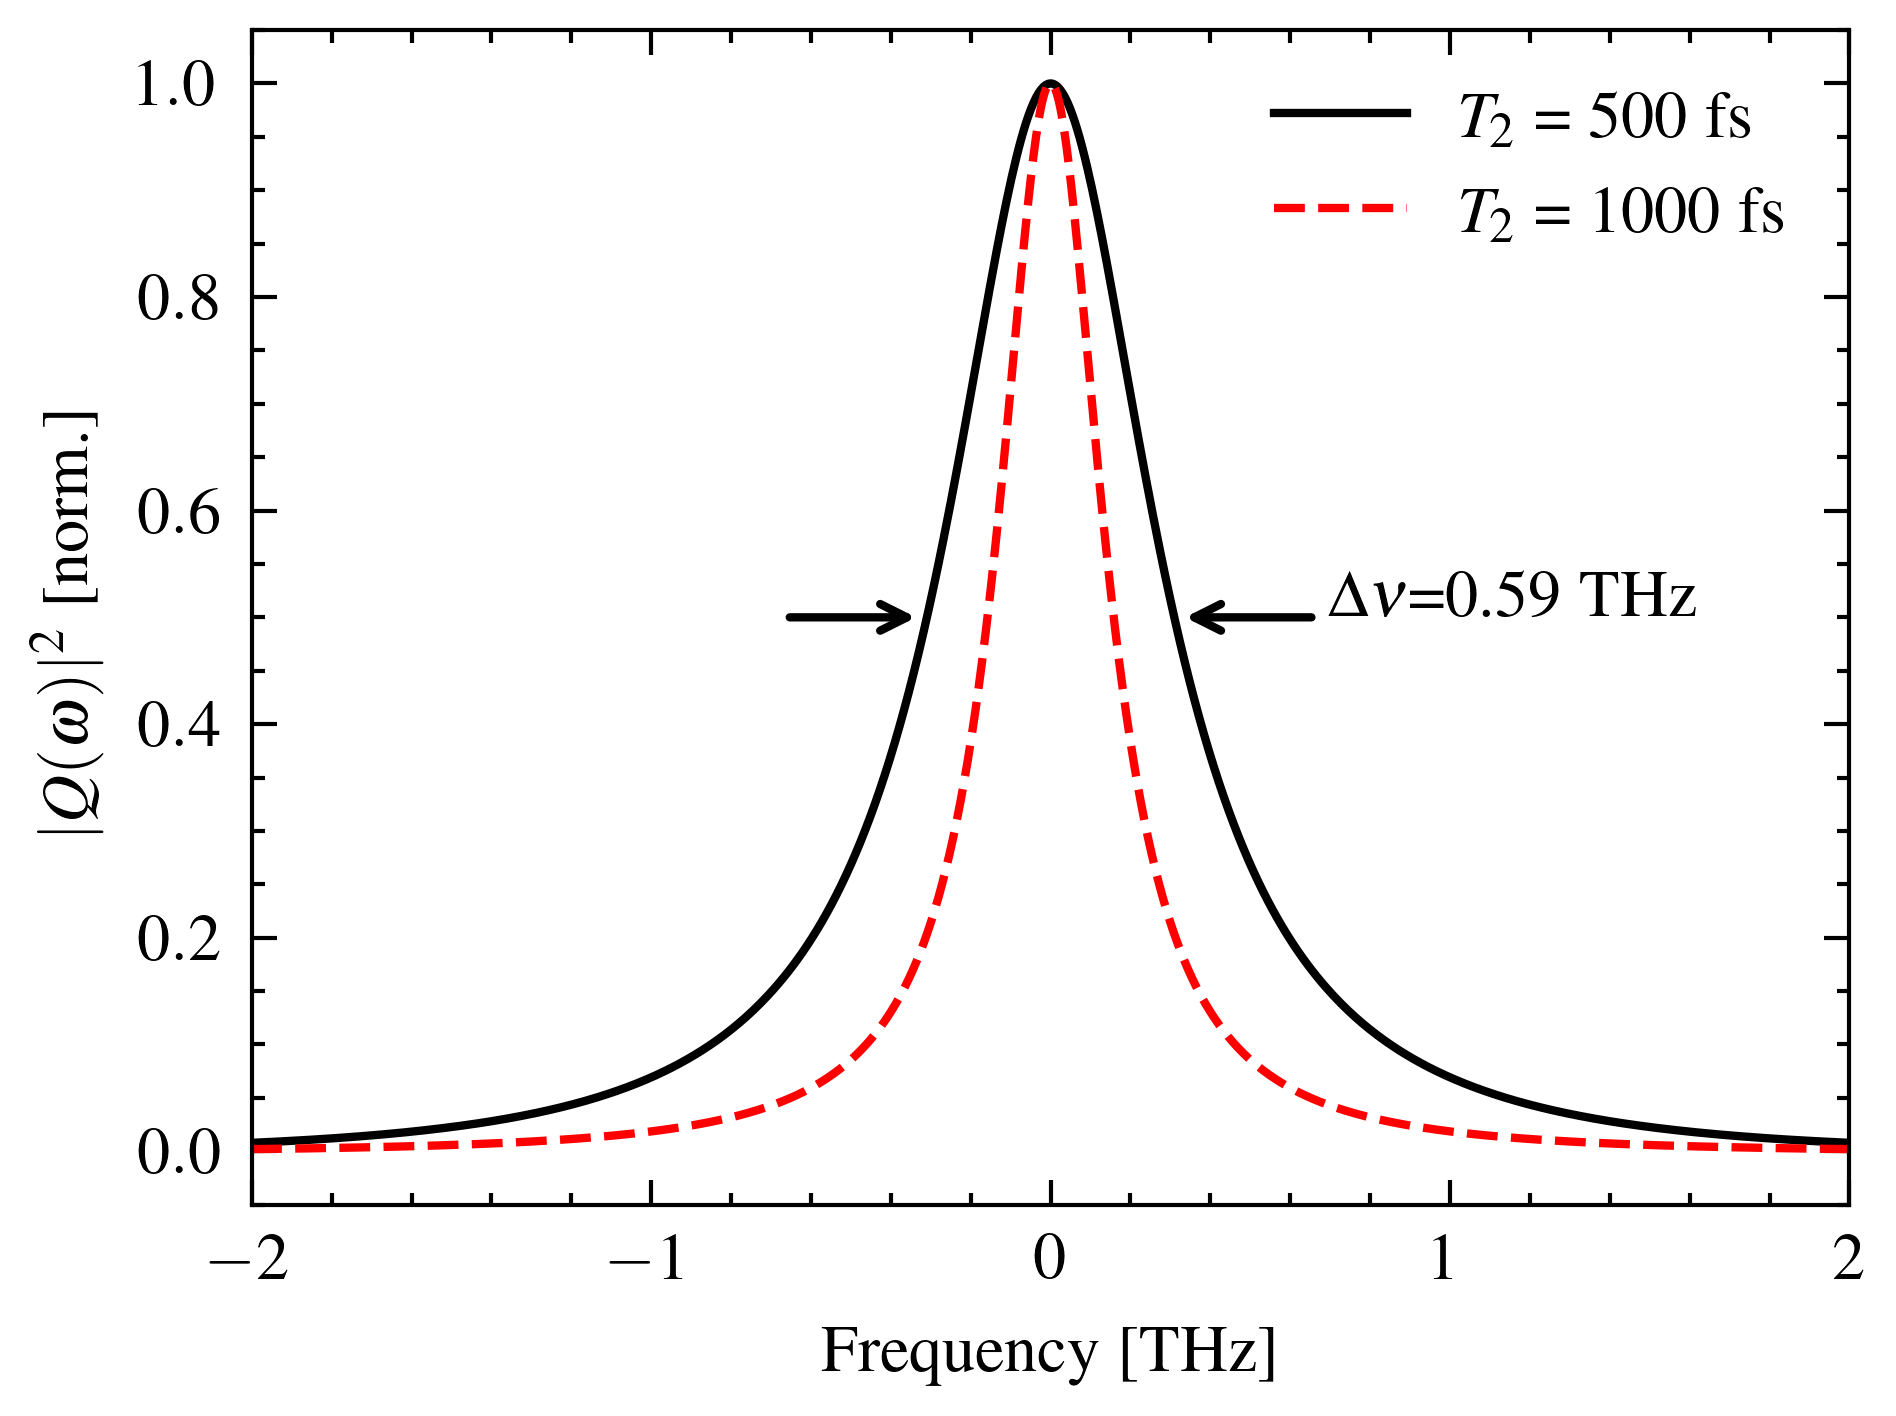

In [43]:
#section 1 del_kL vs xi_as plot
Q_t_exp1 = np.array([np.exp(-t/T2_arr[0]) for t in t_arr1])

N = 2**14
Q_t_arr1_padded = np.zeros(N)
Q_t_arr1_padded[:len(Q_t_arr1)] = Q_t_arr1
Q_t_arr2_padded = np.zeros(N)
Q_t_arr2_padded[:len(Q_t_arr2)] = Q_t_arr2
Q_t_exp1_padded = np.zeros(N)
Q_t_exp1_padded[:len(Q_t_exp1)] = Q_t_exp1

Q_om_arr1 = np.fft.fftshift(np.fft.fft(Q_t_arr1_padded))
Q_om_arr2 = np.fft.fftshift(np.fft.fft(Q_t_arr2_padded))
Q_t_exp1 = np.fft.fftshift(np.fft.fft(Q_t_exp1_padded))
om_arr1 = np.fft.fftshift(np.fft.fftfreq(len(Q_om_arr1),dt_arr[0]))
om_arr2 = np.fft.fftshift(np.fft.fftfreq(len(Q_om_arr2),dt_arr[1]))

plt.plot(om_arr1*1e-12, np.abs(Q_om_arr1/np.max(Q_om_arr1))**2, label = '$T_2$ = '+f'{(T2_arr[0]*1e15):.0f} fs')
plt.plot(om_arr2*1e-12, np.abs(Q_om_arr2/np.max(Q_om_arr2))**2, label = '$T_2$ = '+f'{(T2_arr[1]*1e15):.0f} fs')
#plt.plot(om_arr1*1e-12, np.abs(Q_t_exp1/np.max(Q_t_exp1))**2, label = '$Expected: T_2$ = '+f'{(T2_arr[0]*1e15):.0f} fs')
plt.xlim(-2,2)
draw_line_width(plt.gca(), np.abs(Q_om_arr1/np.max(Q_om_arr1))**2, om_arr1*1e-12, method='lorentzian')
#draw_line_width(plt.gca(), np.abs(Q_t_exp1/np.max(Q_t_exp1))**2, om_arr1*1e-12, method='lorentzian')
plt.xlabel(r'Frequency [THz]')
plt.ylabel(r'$|Q(\omega)|^2$ [norm.]')
plt.legend()
plt.tight_layout()
plt.savefig(r'C:\Users\dinus\OneDrive\Desktop\Oral Comp Exam\Written comp exam\images\sec_2_fig_2.png', dpi=300, transparent=True)

In [44]:
1/np.pi/500e-15/1e12

0.6366197723675814

In [186]:
N

1e+29

In [ ]:
#section 2 2nd part
t_arr = np.arange(-1000e-15,4000e-15,dt_arr[0])
xi_cars = xi_cars_psi(N, omega_as , np.abs(dadq_val),L,xi1,xi2,xi3,n1,n2,n3,nas,w0,tau,m,OmR)
psi_arr = [psi_t(t,tau,T2_arr[0],t_arr) for t in t_arr]
norm_fact = np.trapezoid(psi_arr,t_arr)
psi_0 = psi_t(0,tau,T2_arr[0],t_arr)
print(xi_cars/1e-15)
print(psi_0)
print(norm_fact)
print(psi_0/norm_fact)
print(xi_cars * psi_t(0,tau,T2_arr[0],t_arr))

0.026103738613003927
2.7404307247144247e-39
1822474.2388686321
1.8113515612298268e-51
1512920397878.9158
7.153548732499027e-56


In [122]:
print((2*np.log(2)/np.pi/tau**2)**(1/2))

3321412351339.8003


In [177]:
floor = 1e-25
t_arr = np.arange(-2000e-15,8000e-15,dt_arr[0])
#psi = np.array([psi_t(t,tau,T2_arr[0], t_arr) for t in t_arr])
S1 = S_furuz(t_arr, tau, T2_arr[0], 1e30, 1, 0)
S2 = S_furuz(t_arr, tau, T2_arr[1], 0.7e30, 1, 0)

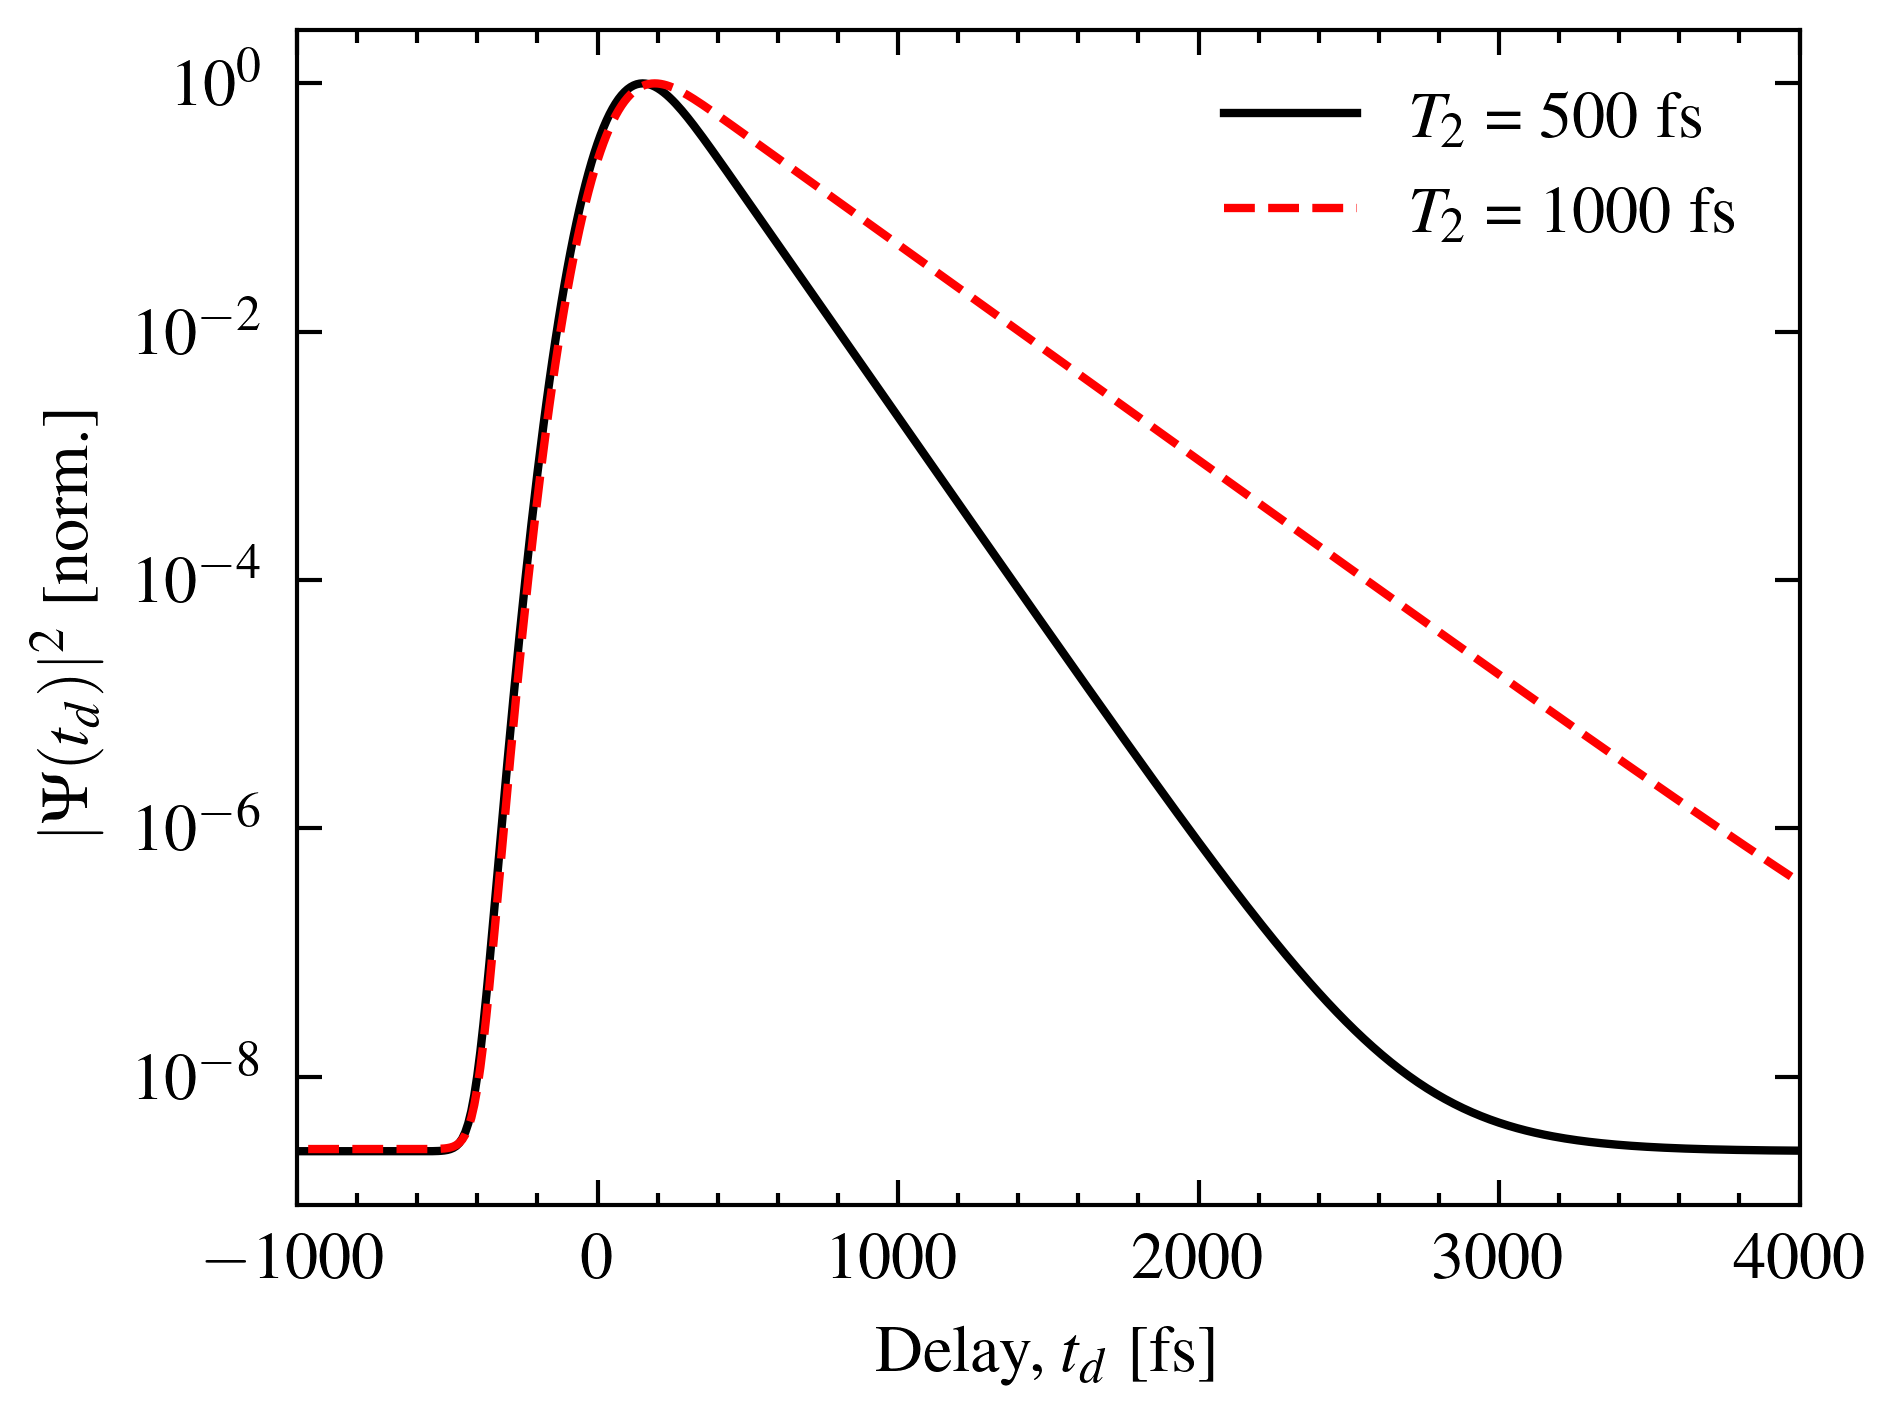

In [178]:
plt.plot(t_arr*1e15, S1**2/np.max(S1**2), label = '$T_2$ = '+f'{(T2_arr[0]*1e15):.0f} fs')
plt.plot(t_arr*1e15, S2**2/np.max(S2**2), label = '$T_2$ = '+f'{(T2_arr[1]*1e15):.0f} fs')
#plt.plot(t_arr2*1e12, Q_t_arr2/np.max(Q_t_arr2), label = '$T_2$ = '+f'{(T2_arr[1]*1e15):.0f} fs')
plt.xlabel(r'Delay, $t_d$ [fs]')
plt.ylabel(r'$|\Psi(t_d)|^2$ [norm.]')
plt.legend()
plt.yscale('log')
plt.xlim(-1000,4000)
plt.tight_layout()
plt.savefig(r'C:\Users\dinus\OneDrive\Desktop\Oral Comp Exam\Written comp exam\images\sec_2_fig_3.png', dpi=300, transparent=True)